In [1]:
#!pip install --upgrade qiskit

In [1]:
#%matplotlib inline
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

from qiskit.circuit.library import EfficientSU2

import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Qiskit Summer School Final Project: VQE

## Some defintions

In [2]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    #ee = ExactEigensolver(qubitOp)
    ee = NumPyEigensolver(qubitOp)
    result = ee.run()
    ref = result['eigenvalues']
    #print('Reference value: {}'.format(ref))
    return ref

In [4]:
backend = BasicAer.get_backend('statevector_simulator')

In [3]:
def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)

In [4]:
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    #freeze_list = [0,6] 
    #remove_list = [3,8]
    print("remove_list=",remove_list)
    print("freeze_list=",freeze_list)

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp #that is: if map_type == 'parity' do two_qibit_reduction, else do nothing 
    qubitOp.chop(10**-10)
    total_en_shift = energy_shift + nuclear_repulsion_energy

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift

### Define some paramters and compute qubit operator

In [15]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(map_type,inter_dist)

HF energy: -8.921712043375118
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]


### Define reference energy

In [16]:
ref = exact_solver(qubitOp)

print("ref. energy=",np.round(np.real(ref[0]),4))
print("total_en_shift",np.round(total_en_shift,4))
exact_energy = np.real(ref[0] + total_en_shift)
print("exact energy=",np.round(exact_energy,4))

ref. energy= -1.0991
total_en_shift -6.782
exact energy= -7.881


In [9]:
backend = BasicAer.get_backend("statevector_simulator")

for maxter in [5,10]:
    optimizer = SLSQP(maxiter=maxter)

    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping=map_type
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping=map_type
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
    print("Max iter.:",maxter,"VQE Result:", vqe_result, "Exact Energy:", exact_energy)

Max iter.: 5 VQE Result: -7.88097950128812 Exact Energy: -7.881015715646995
Max iter.: 10 VQE Result: -7.881015701737771 Exact Energy: -7.881015715646995


In [10]:
optimizer = SLSQP(maxiter=10)

initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping=map_type
) 
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping=map_type
)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result_SLSQP = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result SLSQP:", np.round(vqe_result_SLSQP,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result SLSQP: -7.88102 Exact Energy: -7.88102


In [11]:
counts_SLSQP = counts
en_diff_SLSQP = values - np.real(ref[0])
dev_SLSQP = deviation

In [12]:
optimizer = SPSA(max_trials=200)

counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result_SPSA = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result SPSA:", np.round(vqe_result_SPSA,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result SPSA: -7.74756 Exact Energy: -7.88102


In [13]:
counts_SPSA = counts
en_diff_SPSA = values - np.real(ref[0])
deviation_SPSA = deviation

In [14]:
optimizer = COBYLA(maxiter=200, tol=0.001)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer,callback=store_intermediate_result)
vqe_result_COBYLA = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result COBYLA:", np.round(vqe_result_COBYLA,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result COBYLA: -7.88101 Exact Energy: -7.88102


In [15]:
counts_COBYLA = counts
en_diff_COBYLA = values - np.real(ref[0])
deviation_COBYLA = deviation

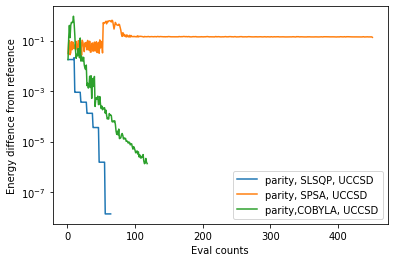

In [16]:
plt.plot(counts_SLSQP,en_diff_SLSQP,label="parity, SLSQP, UCCSD")
plt.plot(counts_SPSA,en_diff_SPSA,label="parity, SPSA, UCCSD")
plt.plot(counts_COBYLA,en_diff_COBYLA,label="parity,COBYLA, UCCSD")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

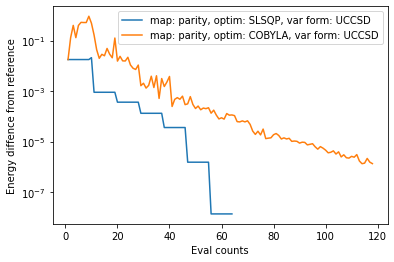

In [17]:
plt.plot(counts_SLSQP,en_diff_SLSQP,label="map: parity, optim: SLSQP, var form: UCCSD")
plt.plot(counts_COBYLA,en_diff_COBYLA,label="map: parity, optim: COBYLA, var form: UCCSD")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

In [18]:
print("VQE Result SLSQP:", np.round(vqe_result_SLSQP,5), "Exact Energy:", np.round(exact_energy,5))
print("VQE Result SPSA:", np.round(vqe_result_SPSA,5), "Exact Energy:", np.round(exact_energy,5))
print("VQE Result COBYLA:", np.round(vqe_result_COBYLA,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result SLSQP: -7.88102 Exact Energy: -7.88102
VQE Result SPSA: -7.74756 Exact Energy: -7.88102
VQE Result COBYLA: -7.88101 Exact Energy: -7.88102


### Now I change the variational form 

I try with RY variational form, and I choose COBYLA as optimizer

In [19]:
depth = 2
num_qubits=qubitOp.num_qubits
RY_var_form = RY(num_qubits, depth=depth)

In [20]:
var_form=RY_var_form
optimizer = COBYLA(maxiter=100, tol=0.001)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
result_RY = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result var form RY:", np.round(result_RY,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result var form RY: -7.86161 Exact Energy: -7.88102


In [21]:
var_form=RY_var_form
optimizer = COBYLA(maxiter=800, tol=0.001)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
result_RY = np.real(vqe.run(backend)['eigenvalue'] + total_en_shift)
print("VQE Result var form RY:", np.round(result_RY,5), "Exact Energy:", np.round(exact_energy,5))

VQE Result var form RY: -7.87685 Exact Energy: -7.88102


In [22]:
counts_RY_COBYLA = counts
en_diff_RY_COBYLA = values - np.real(ref[0])
deviation_RY_COBYLA = deviation

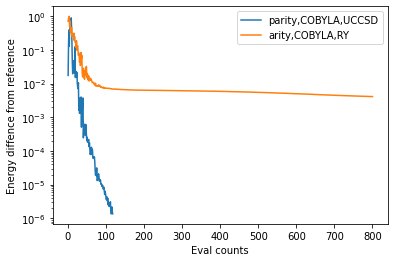

In [23]:
plt.plot(counts_COBYLA,en_diff_COBYLA,label="parity,COBYLA,UCCSD")
plt.plot(counts_RY_COBYLA,en_diff_RY_COBYLA,label="arity,COBYLA,RY")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

### I compare with different depths

depth: 1 VQE Result var. form RY from ref: 0.0177
depth: 2 VQE Result var. form RY from ref: 0.01247
depth: 3 VQE Result var. form RY from ref: 0.0018
depth: 4 VQE Result var. form RY from ref: 0.00631
depth: 5 VQE Result var. form RY from ref: 0.03941


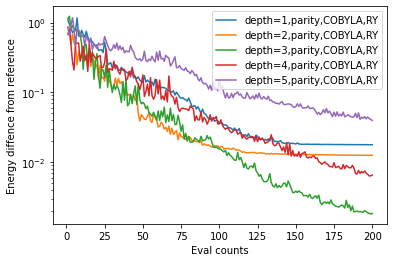

In [24]:
for depth in [1,2,3,4,5]:
    num_qubits = qubitOp.num_qubits
    var_form = RY(num_qubits, depth=depth)
    optimizer = COBYLA(maxiter=200, tol=0.001)
    counts=[]
    values=[]
    params=[]
    deviation=[]
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    result_RY = np.real(vqe.run(backend)['eigenvalue'] - ref[0])
    print("depth:", depth,"VQE Result var. form RY from ref:", np.round(result_RY,5))
    counts_RY_COBYLA = counts
    en_diff_RY_COBYLA = values - np.real(ref[0])
    plt.plot(counts_RY_COBYLA,en_diff_RY_COBYLA,label="depth="+str(depth)+",parity,COBYLA,RY")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

### Now I try with noise

In [11]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'

device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map

#basis_gates = noise_model.basis_gates

noise_model = NoiseModel.from_backend(device.properties())
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'measure', 'id', 'u2', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [17]:
simulator = Aer.get_backend('qasm_simulator')

In [18]:
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [19]:
quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

In [60]:
var_form = RY(num_qubits=4, depth=1)
#optimizer = COBYLA(maxiter=200, tol=0.001)
optimizer = SPSA(max_trials=100)
#var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer=optimizer,callback=store_intermediate_result)
vqe_result_RY_SPSA_d1 = np.real(vqe.run(quantum_instance)['eigenvalue'])

In [59]:
print("VQE results with: noise, mapp.='parity',var. form=RY,depth=1,optim.=SPSA")
print("VQE Energy:",np.round(vqe_result+total_en_shift,5), "Exact Energy:", np.round(exact_energy,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))

VQE results with: noise, mapp.='parity',var. form=RY,depth=1,optim.=SPSA
VQE Energy: -7.7629 Exact Energy: -7.88102
Energy diff: 0.1181


In [53]:
counts_noise_SPSA_RY = counts
en_diff_noise_SPSA_RY = values - np.real(ref[0])
deviation_noise_SPSA_RY = deviation

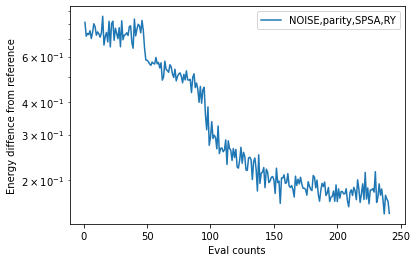

In [54]:
plt.plot(counts_noise_SPSA_RY,en_diff_noise_SPSA_RY,label="NOISE,parity,SPSA,RY")
plt.xlabel('Eval counts')
plt.ylabel('Energy diffence from reference')
plt.yscale("log")
plt.legend()

In [55]:
var_form = RY(num_qubits=4, depth=2)
#optimizer = COBYLA(maxiter=200, tol=0.001)
optimizer = SPSA(max_trials=100)
#var_form = EfficientSU2(qubitOp.num_qubits, entanglement="linear")
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer=optimizer,callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])

In [58]:
print("VQE results with: noise, mapp.='parity',var. form=RY,depth=2,optim.=SPSA")
print("VQE Energy:",np.round(vqe_result+total_en_shift,5), "Exact Energy:", np.round(exact_energy,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))

VQE results with: noise, mapp.='parity',var. form=RY,depth=2,optim.=SPSA
VQE Energy: -7.7629 Exact Energy: -7.88102
Energy diff: 0.1181


HF energy: -8.921712043375118
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
total_en_shift -6.782
ref. energy= -1.0991
Exact Energy: -7.881
inter distance= 1.5 Angstroms
VQE results with: noise of ibmq_essex, mapp.='parity',init stae=HF,var. form=RYRZ,optim.=SPSA


No handles with labels found to put in legend.


-------------------------------
VQE results with: depth=1
VQE Energy: -7.7935
Energy diff: 0.0875


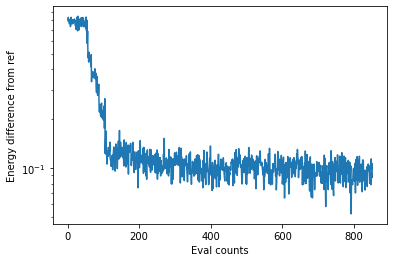

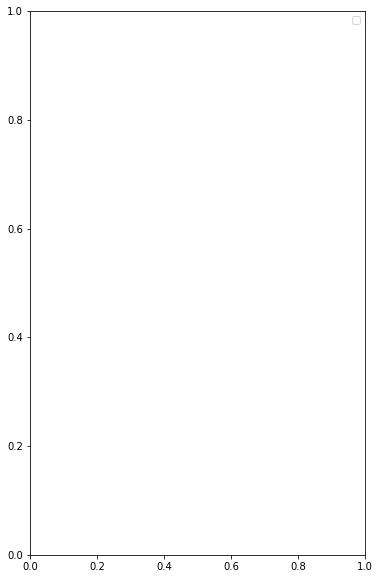

In [9]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping=map_type)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)
print("================================")
print("inter distance=",inter_dist,"Angstroms")
print("VQE results with: noise of ibmq_essex, mapp.='parity',init stae=HF,var. form=RYRZ,optim.=SPSA")
depth=1
num_qubits = qubitOp.num_qubits
var_form = RYRZ(num_qubits=num_qubits, depth=depth)
optimizer = SPSA(max_trials=400)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
print("-------------------------------")
print("VQE results with: depth="+str(depth))
print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
en_diff = values - np.real(ref[0])
plt.figure(figsize=(8,6))
plt.plot(counts,en_diff,label="Noise,depth="+str(depth)+",parity,SPSA,RYRZ")

plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.legend()

In [ ]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping=map_type)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

print("VQE results with: noise of ibmq_essex, mapp.='parity',init stae=HF,var. form=RYRZ,optim.=SPSA")
for depth in [3,4,5,6]:
    num_qubits = qubitOp.num_qubits
    var_form = RYRZ(num_qubits=num_qubits, depth=depth)
    optimizer = SPSA(max_trials=400)
    counts=[]
    values=[]
    params=[]
    deviation=[]
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
    print("-------------------------------")
    print("VQE results with: depth="+str(reps))
    print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
    print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
    en_diff = values - np.real(ref[0])
    plt.plot(counts,en_diff,label="Noise,depth="+str(depth)+",parity,SPSA,RYRZ")

plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.figure(figsize=(6,10))
plt.legend()

Process ForkProcess-3826:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/opt/conda/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


### Change the intial state to Zero

HF energy: -8.92171204337512
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
total_en_shift -6.782
ref. energy= -1.0991
Exact Energy: -7.881
inter distance= 1.5 Angstroms
VQE results with: noise of ibmq_essex, mapp.='parity',init stae=HF,var. form=RYRZ,optim.=SPSA
-------------------------------
VQE results with: depth=1
VQE Energy: -7.74649
Energy diff: 0.1345


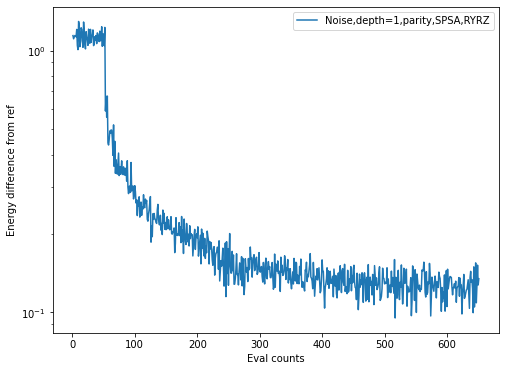

In [10]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

init_state = Zero(qubitOp.num_qubits)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)
print("================================")
print("inter distance=",inter_dist,"Angstroms")
print("VQE results with: noise of ibmq_essex, mapp.='parity',init stae=HF,var. form=RYRZ,optim.=SPSA")
depth=1
num_qubits = qubitOp.num_qubits
var_form = RYRZ(num_qubits=num_qubits, depth=depth)
optimizer = SPSA(max_trials=300)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
print("-------------------------------")
print("VQE results with: depth="+str(depth))
print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
en_diff = values - np.real(ref[0])
plt.figure(figsize=(8,6))
plt.plot(counts,en_diff,label="Noise,depth="+str(depth)+",parity,SPSA,RYRZ")

plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.legend()

In [ ]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

init_state = Zero(qubitOp.num_qubits)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

num_qubits = qubitOp.num_qubits
optimizer = SPSA(max_trials=400)

print("================================")
print("VQE results with: noise of ibmq_essex, mapp.='parity',init stae=Zero,var. form=RYRZ,optim.=SPSA")

for depth in [1,2,3,4,5,6]:
    var_form = RYRZ(num_qubits=num_qubits, depth=depth)
    counts=[]
    values=[]
    params=[]
    deviation=[]
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
    print("-------------------------------")
    print("VQE results with: depth="+str(depth))
    print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
    print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
    en_diff = values - np.real(ref[0])
    plt.errorbar(counts,en_diff,yerr=deviation,label="Noise,depth="+str(depth)+",parity,SPSA,RYRZ")
    
plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.legend()

In [ ]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

init_state = Zero(qubitOp.num_qubits)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)
print("================================")
print("inter distance=",inter_dist,"Angstroms")
print("VQE results with: noise of ibmq_essex, mapp.='parity',init stae=HF,var. form=RYRZ,optim.=SPSA")
depth=2
num_qubits = qubitOp.num_qubits
var_form = RYRZ(num_qubits=num_qubits, depth=depth)
optimizer = SPSA(max_trials=300)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
print("-------------------------------")
print("VQE results with: depth="+str(depth))
print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
en_diff = values - np.real(ref[0])
plt.figure(figsize=(8,6))
plt.plot(counts,en_diff,label="Noise,depth="+str(depth)+",parity,SPSA,RYRZ")

plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.legend()

### Change the var form to EfficientSU2

HF energy: -8.921712043375123
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
total_en_shift -6.782
ref. energy= -1.0991
Exact Energy: -7.881
inter distance= 1.5 Angstroms
VQE sim. results with: noise:ibmq_essex,mapp.='parity',init state=Zero,var.form=EfficientSU2,optim.=SPSA
-------------------------------
VQE results with: depth=1
VQE Energy: -7.61959
Energy diff: 0.2614


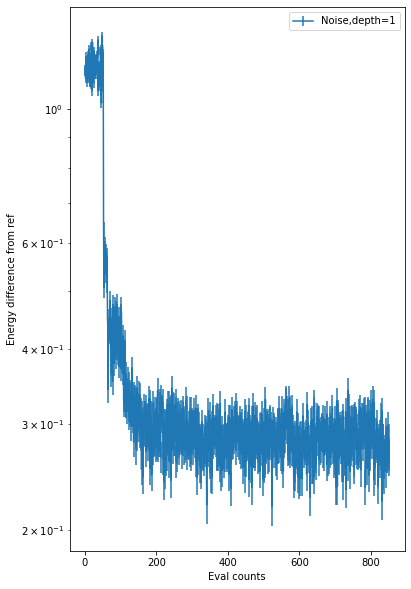

In [11]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

init_state = Zero(qubitOp.num_qubits)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

num_qubits = qubitOp.num_qubits
optimizer = SPSA(max_trials=400)

print("================================")
print("inter distance=",inter_dist,"Angstroms")
print("VQE sim. results with: noise:ibmq_essex,mapp.='parity',init state=Zero,var.form=EfficientSU2,optim.=SPSA")

plt.figure(figsize=(6,10))
reps=1
var_form = EfficientSU2(num_qubits, entanglement="linear",reps=reps)
#var_form = RYRZ(num_qubits=num_qubits, depth=depth)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
print("-------------------------------")
print("VQE results with: depth="+str(reps))
print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
en_diff = values - np.real(ref[0])
plt.errorbar(counts,en_diff,yerr=deviation,label="Noise,depth="+str(reps))

plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.legend()

In [ ]:
inter_dist = 1.5
map_type='parity'

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))

init_state = Zero(qubitOp.num_qubits)

chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

num_qubits = qubitOp.num_qubits
optimizer = SPSA(max_trials=400)

print("================================")
print("inter distance=",inter_dist,"Angstroms")
print("VQE sim. results with: noise:ibmq_essex,mapp.='parity',init state=Zero,var.form=EfficientSU2,optim.=SPSA")

plt.figure(figsize=(6,10))
reps=2
var_form = EfficientSU2(num_qubits, entanglement="linear",reps=reps)
#var_form = RYRZ(num_qubits=num_qubits, depth=depth)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
print("-------------------------------")
print("VQE results with: depth="+str(reps))
print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
en_diff = values - np.real(ref[0])
plt.errorbar(counts,en_diff,yerr=deviation,label="Noise,depth="+str(reps))

plt.xlabel('Eval counts')
plt.ylabel('Energy difference from ref')
plt.yscale("log")
plt.legend()

In [ ]:
map_type='parity'

distances=[]
exact_energies=[]
vqe_energies=[]
energies_diff=[]
counts_ar=[]
values_ar=[]
deviation_ar=[]

for inter_dist in np.arange(0.4,3.7,0.4):

    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
        map_type,
        inter_dist)
    print("total_en_shift",np.round(total_en_shift,4))

    ref = exact_solver(qubitOp)
    print("ref. energy=",np.round(np.real(ref[0]),4))

    exact_energy = np.real(ref[0] + total_en_shift)
    print("Exact Energy:", np.round(exact_energy,4))
    exact_energies.append(exact_energy)
    
    init_state = Zero(qubitOp.num_qubits) 

    simulator = Aer.get_backend('qasm_simulator')
    chip_name = 'ibmq_essex'
    device = provider.get_backend(chip_name)
    coupling_map = device.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device.properties())      

    simulator = Aer.get_backend('qasm_simulator')

    quantum_instance = QuantumInstance(backend=simulator, 
                                       shots=1000, 
                                       noise_model=noise_model, 
                                       coupling_map=coupling_map,
                                       measurement_error_mitigation_cls=CompleteMeasFitter,
                                       cals_matrix_refresh_period=30)

    num_qubits = qubitOp.num_qubits
    optimizer = SPSA(max_trials=400)

    print("================================")
    print("inter distance=",inter_dist,"Angstroms")
    print("VQE sim. results without noise,mapp.='parity',init state=Zero,var.form=EfficientSU2,optim.=SPSA")

    reps=2
    print("-------------------------------")
    print("VQE results with: reps="+str(reps))
    var_form = EfficientSU2(num_qubits, entanglement="linear",reps=reps)
    counts=[]
    values=[]
    params=[]
    deviation=[]
    vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
    vqe_result = np.real(vqe.run(simulator)['eigenvalue'])
    vqe_energies.append(vqe_result+total_en_shift)
    energies_diff.append(vqe_result-np.real(ref[0]))
    counts_ar.append(counts)
    values_ar.append(values)
    deviation_ar.append(deviation)
    print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
    print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))

In [26]:
map_type='parity'

inter_dist = 0.4

qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
    map_type,
    inter_dist)
print("total_en_shift",np.round(total_en_shift,4))

ref = exact_solver(qubitOp)
print("ref. energy=",np.round(np.real(ref[0]),4))

exact_energy = np.real(ref[0] + total_en_shift)
print("Exact Energy:", np.round(exact_energy,4))
exact_energies.append(exact_energy)

init_state = Zero(qubitOp.num_qubits) 

simulator = Aer.get_backend('qasm_simulator')
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())      

simulator = Aer.get_backend('qasm_simulator')

quantum_instance = QuantumInstance(backend=simulator, 
                                   shots=1000, 
                                   noise_model=noise_model, 
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

num_qubits = qubitOp.num_qubits
optimizer = SPSA(max_trials=400)

print("================================")
print("inter distance=",inter_dist,"Angstroms")
print("VQE sim. results with noise,mapp.='parity',init state=Zero,var.form=EfficientSU2,optim.=SPSA")

reps=2
print("-------------------------------")
var_form = EfficientSU2(num_qubits, entanglement="linear",reps=reps)
counts=[]
values=[]
params=[]
deviation=[]
vqe = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)
vqe_result = np.real(vqe.run(quantum_instance)['eigenvalue'])
print("VQE Energy:",np.round(vqe_result+total_en_shift,5))
print("Energy diff:", np.round(vqe_result-np.real(ref[0]),4))
print("counts:",counts)
print("vqe_energy:",values+total_en_shift)
print("energy_diff:",values-np.real(ref[0]))

HF energy: -10.579088026010968
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
total_en_shift -5.699
ref. energy= -0.9219
Exact Energy: -6.6209
inter distance= 0.4 Angstroms
VQE sim. results with noise,mapp.='parity',init state=Zero,var.form=EfficientSU2,optim.=SPSA
-------------------------------
VQE Energy: -6.56383
Energy diff: 0.0571
counts: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 

In [73]:
distances=[0.4,0.8, 1.2, 1.6, 2., 2.4, 2.6]
exact_energies1=[-6.6209,-7.631,-7.8507, -7.8811, -7.8602, -7.8299, -7.8168]
vqe_energies=[-6.56383,-7.60787, -7.62231, -7.7427, -7.73981, -7.77378, -7.6788]
energies_diff=[vqe_energies[i]-np.round(exact_energies[i],4) for i in range(0,len(vqe_energies))]
counts=range(1,852)
values_ar=[]
deviation_ar=[]

In [69]:
exact_energies=[]
for inter_dist in np.arange(0.4,3.7,0.1):

    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, total_en_shift = compute_LiH_qubitOp(
        map_type,
        inter_dist)
    #print("total_en_shift",np.round(total_en_shift,4))

    ref = exact_solver(qubitOp)
#    print("ref. energy=",np.round(np.real(ref[0]),4))

    exact_energy = np.real(ref[0] + total_en_shift)
#    print("Exact Energy:", np.round(exact_energy,4))
    exact_energies.append(exact_energy)

HF energy: -10.579088026010972
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -10.203473360061942
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.94542710594224
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.75384720306156
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.600184702182101
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.469677376536119
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.354893768508564
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.25195375172978
# of electrons: 4
# of spin orbitals: 12
remove_list= [2, 3, 7, 8]
freeze_list= [0, 6]
HF energy: -9.158558852856915
# of electrons: 4
# of spin orbital

In [68]:
dists=np.arange(0.4,3.7,0.1)
print(dists)
print(exact_energies)

[0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1
 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6]
[-6.6209, -7.631, -7.8507, -7.8811, -7.8602, -7.8299, -7.8168]


In [39]:
counts_ar.append(counts)
values_ar.append(values)
deviation_ar.append(deviation)

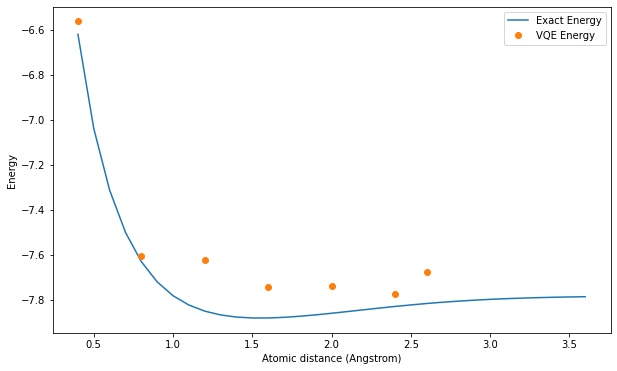

In [70]:
plt.figure(figsize=(10,6))
plt.plot(dists, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies,'o', label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

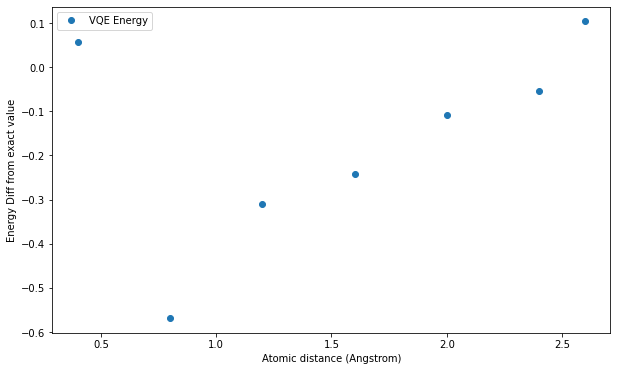

In [74]:
plt.figure(figsize=(10,6))
plt.plot(distances, energies_diff,'o', label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy Diff from exact value')
plt.legend()
plt.show()